# **Table of Contents:** (Use the link to navigate sections)

# * [Exploratory Data Analysis (EDA)](#eda)
   ## - [Data Exploration and Data Preprocessing](#data-expprocess)
# * [Model](#model)
   ## - [Create Pytorch Dataset](#create-dataset)
   ## - [Model Definition](#model-definition)
   ## - [Define Loss Function](#loss-function)
   ## - [Training](#training)
# * [Evaluation of the Model](#evaluation)
   ## - [Results](#results)
   ## - [Tuning](#tuning)
# * [Credits/References](#credit-references)

---
<a id="eda"></a>
# Exploratory Data Analysis (EDA)
<a id="data-expprocess"></a>
## Data Exploration and Data Preprocessing:

---


In [1]:
# first import all of the packages required in this entire project: 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
import tensorflow as tf
import seaborn as sns
import random
from skimage.color import label2rgb
from sklearn.model_selection import StratifiedGroupKFold
from glob import glob
from torch.cuda.amp import GradScaler, autocast
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import copy
import joblib
from tqdm import tqdm
tqdm.pandas()
import gc
from collections import defaultdict
import time

In [2]:
os.mkdir('/kaggle/working/segmentation_models_pytorch') #only required once
!cp -r /kaggle/input/d/kevinwonjunecho/uwmadisonmodels* ./segmentation_models_pytorch

In [3]:
!pip install /kaggle/working/segmentation_models_pytorch/uwmadisonmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
!pip install /kaggle/working/segmentation_models_pytorch/uwmadisonmodels/efficientnet_pytorch-0.7.1/efficientnet_pytorch-0.7.1
!pip install /kaggle/working/segmentation_models_pytorch/uwmadisonmodels/timm-0.4.12-py3-none-any.whl
!pip install /kaggle/working/segmentation_models_pytorch/uwmadisonmodels/segmentation_models_pytorch-0.3.1-py3-none-any.whl
!pip install /kaggle/working/segmentation_models_pytorch/uwmadisonmodels/resnet_pytorch-0.2.0-py2.py3-none-any.whl


Processing ./segmentation_models_pytorch/uwmadisonmodels/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
  Preparing metadata (setup.py) ... - done
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=3808e4e0d4295e9f74313e5c9199ead9d57cb26c93ae64ad2dc3ef43a77e9ead
  Stored in directory: /root/.cache/pip/wheels/91/3e/d6/3ced8f09bda4587ea6d793851238d229d5f5c871aa1891931a
Successfully built pretrainedmodels
Processing ./segmentation_models_pytorch/uwmadisonmodels/efficientnet_pytorch-0.7.1/efficientnet_pytorch-0.7.1
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=fadf884be1cf90421d1ff8218ea835ddc1d72d67177dc55f8b045d03f168003e
  Stored in directory: /root/.cache/pip/wheels/9a/f3/66/004f52bf88d78f4e8323fa605d48466381ba63c091cfbd4da1
Successfully built efficientnet-pytorch
Processing ./segmentation_models_pytorch/uwmadisonmodels/t

In [4]:
import segmentation_models_pytorch as smp 

In [5]:
# define all necessary paths (on kaggle):
data_path_dir = "/kaggle/input/uw-madison-gi-tract-image-segmentation"
train_dir = os.path.join(data_path_dir,"train")
train_csv_dir = os.path.join(data_path_dir, "train.csv")
sample_submission_dir = os.path.join(data_path_dir, "sample_submission.csv") #submission path
entire_train_image = glob(os.path.join(train_dir,"**","**.png"), recursive = True) #list of all training images

---
### Check out how the train.csv and sample_submission.csv looks like: 
---


In [6]:
df_train = pd.read_csv(train_csv_dir)
sample_submission_csv = pd.read_csv(sample_submission_dir)

display(df_train)
display(sample_submission_csv)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
...,...,...,...
115483,case30_day0_slice_0143,small_bowel,NaN
115484,case30_day0_slice_0143,stomach,NaN
115485,case30_day0_slice_0144,large_bowel,NaN
115486,case30_day0_slice_0144,small_bowel,NaN


,id,class,predicted


---
### Looking at the train.csv, there are some informations that we can extract out of the id, and also the file path. It is known that:

- 1. Case ID, day, and slice identifier (number) is in the id column.
- 2. Most importantly, something called the **"RLE mask"** is included in the segmentation column (this will be explained soon!)
- 3. The file path contains slice height and width (integer in pixels).

- Example of a file path name: "/kaggle/input/uw-madison-gi-tract-image-segmentation/train/case101/case101_day20/scans/slice_0001_266_266_1.50_1.50.png"


### Therefore, write helper functions to get this data and turn it in to a new dataframe, replacing the one above:

---

In [7]:
def edit_csv_data(df_row):
    '''
    df_row = each row of df to be edited to include columns with individual features
    like case, day, slice, etc. 
    Returns: the converted, new row of the df. 
    '''
    row_data = df_row['id'].split('_')
    # as seen in train_csv above, case is data[0], day is data[1], slice is data[3]
    case = int(row_data[0].replace('case',''))
    day = int(row_data[1].replace('day',''))
    slices = int(row_data[3])
    # new row:
    df_row['slices'] = slices
    df_row['day'] = day
    df_row['case_number'] = case
    return df_row

def edit_path_data(df_row):
    '''
    df_row = each row of df to be edited to include columns with individual features
    like case, day, slice, etc. 
    Returns: the converted, new row of the df. 
    '''
    path = df_row['image_file_path']
    path_data = path.split('/')
    # as seen above in example file name:
    # do the same thing as above:
    case = int(path_data[-4].replace('case',''))
    day = int(path_data[-3].split('_')[1].replace('day',''))
    slices = int(path_data[-1].split('_')[1])
    width = int(path_data[-1].split('_')[2])
    height = int(path_data[-1].split('_')[3])
    # new row:
    df_row['slices'] = slices
    df_row['day'] = day
    df_row['case_number'] = case
    df_row['height'] = height
    df_row['width'] = width
    return df_row

### Now use the helper functions to edit and create a new train dataframe:

In [8]:
new_df_train1 = df_train.apply(edit_csv_data, axis = 1)
new_df_train1.head(n=5)

,id,class,segmentation,slices,day,case_number
0,case123_day20_slice_0001,large_bowel,NaN,1,20,123
1,case123_day20_slice_0001,small_bowel,NaN,1,20,123
2,case123_day20_slice_0001,stomach,NaN,1,20,123
3,case123_day20_slice_0002,large_bowel,NaN,2,20,123
4,case123_day20_slice_0002,small_bowel,NaN,2,20,123


In [9]:
# all images in train path:
all_paths = glob('/kaggle/input/uw-madison-gi-tract-image-segmentation/train/**/**/**/*')
new_df_train2 = pd.DataFrame(all_paths, columns=['image_file_path'])
new_df_train2 = new_df_train2.apply(edit_path_data, axis=1)
new_df_train2.head(n=5)

,image_file_path,slices,day,case_number,height,width
0,/kaggle/input/uw-madison-gi-tract-image-segmen...,6,14,36,266,266
1,/kaggle/input/uw-madison-gi-tract-image-segmen...,82,14,36,266,266
2,/kaggle/input/uw-madison-gi-tract-image-segmen...,113,14,36,266,266
3,/kaggle/input/uw-madison-gi-tract-image-segmen...,76,14,36,266,266
4,/kaggle/input/uw-madison-gi-tract-image-segmen...,125,14,36,266,266


In [10]:
# then merge the two to create the final, new df_train:
new_df_train = new_df_train1.merge(new_df_train2, on=['case_number','day','slices'])
new_df_train.head(n=-20)

,id,class,segmentation,slices,day,case_number,image_file_path,height,width
0,case123_day20_slice_0001,large_bowel,NaN,1,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
1,case123_day20_slice_0001,small_bowel,NaN,1,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
2,case123_day20_slice_0001,stomach,NaN,1,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
3,case123_day20_slice_0002,large_bowel,NaN,2,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
4,case123_day20_slice_0002,small_bowel,NaN,2,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
...,...,...,...,...,...,...,...,...,...
115463,case30_day0_slice_0136,stomach,NaN,136,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
115464,case30_day0_slice_0137,large_bowel,18746 2 19010 8 19040 3 19274 25 19302 12 1953...,137,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
115465,case30_day0_slice_0137,small_bowel,21457 6 21722 10 21987 15 22252 18 22517 21 22...,137,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266
115466,case30_day0_slice_0137,stomach,NaN,137,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266


---
### While everything in the new train dataframe looks great, there seems to be quite a lot of NaN's in the segmentation. Let's just check out the ratio first:
---

(array([0, 1]), array([33913, 81575]))


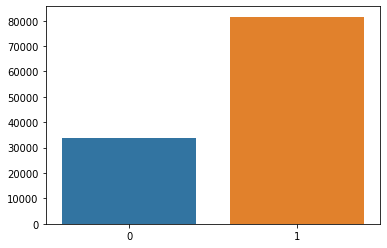

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #ignore futurewarnings

seg_list = list(new_df_train['segmentation'])
nan_or_not = np.array([1 if isinstance(x,float) else 0 for x in seg_list]) #nan is a float
values = np.unique(nan_or_not, return_counts=True)
ex_df = pd.DataFrame(values, columns = values[0])
ex_df.drop(index=ex_df.index[0], axis=0, inplace=True)
sns.barplot(data=ex_df)
print(values)

---
### 81575 NaN's and 33913 NaN's, but this is actually misleading– since each slice has three rows– one for each segmentation. Not a lot of images have all three organs in the image, so there is bound to be much more NaN's in the dataframe. We can take this into account later.
### Now let's investigate a little bit more on the dataframe to know more about our data:
---

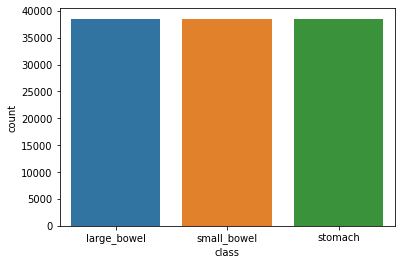

In [12]:
sns.countplot(new_df_train['class'])
plt.show()

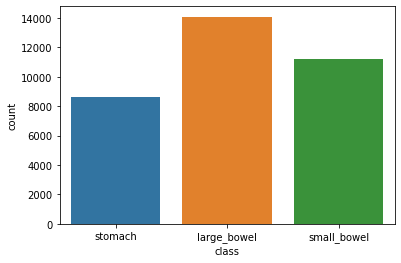

In [13]:
sns.countplot(new_df_train[new_df_train['segmentation'].notnull()]['class'])
plt.show()

---
### As seen above, we have equal number of classes in the data, but they are unequal when we only see non NaN's. There are the most number of large bowel, than small bowel, and least numebr of stomach. We'll probably have to use stratification to take this class imbalance into account.

### Shifting gears from the training data to images, we can now check out how some sample images from the training set looks like:
---

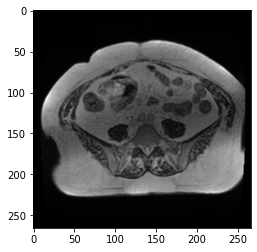

In [14]:
len(entire_train_image) #38496 total training images
# open two random images and show them:
sample_img1 = cv2.imread(entire_train_image[500], -1) # -1 is unchanged imread mode
sample_ra1 = np.array(sample_img1)
plt.imshow(sample_ra1,cmap='gray')

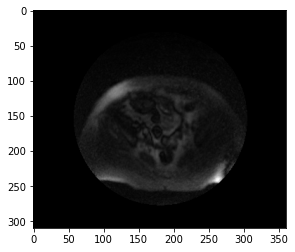

In [15]:
sample_img2 = cv2.imread(entire_train_image[5000], -1) # -1 is unchanged imread mode
sample_ra2 = np.array(sample_img2)
plt.imshow(sample_ra2,cmap='gray')

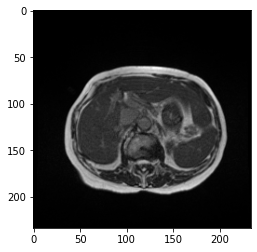

In [16]:
sample_img3 = cv2.imread(entire_train_image[25000], -1) # -1 is unchanged imread mode
sample_ra3 = np.array(sample_img3)
plt.imshow(sample_ra3,cmap='gray')

---
### We can confirm here that the images are small (usually 200-300 pixels by 200-300 pixels (a square)) and grayscale (not RGB). 

### Now, there's one **important** distinction to make: When we make inference after training our model, we can't submit an image with predicted segmentation– it will be too big (Images are big!). What we use instead of images is something called *run-length encoded masks, or RLE's.* This RLE is the one that's in the segmentation column of the training data.

- An example of a RLE is: **1 3 500 5**, which would mean pixel values of 1,2,3 and pixel values of 500,501,502,503,504. 
- For example, if a stomach is labeled in the image in pixel values 1,2,3 and pixel values 500,501,502,503,504, it would have such RLE above. 
- Note that the RLE encoding should be done with a binary mask: 0 (not masked) for background and 1 for masked. 
- Therefore, the most of pre-processing on the training data would be converting these images to binary masks and then encoding them to RLE masks. This makes everything fast: training, infering, and submitting the submission results.


### Below are the helper functions to do this:
---

In [17]:
def decode_rle(rle_mask, mask_shape):
    '''
    rle_mask = As explained above, this is a rle encoded mask, which is 
    string-formatted by default (ex."2 5 10 3")
    mask_shape = desired shape of 2d array to return
    Returns: As explained above, returns a binary array with the desired mask_shape
    , where 0 is background (no mask), and 1 is mask. 
    '''
    # comment will describe what each line does and what would happen for the ex.: "2 5 10 3"
    rle_mask = ''.join(rle_mask)
    split_rle_mask = rle_mask.split() # split in to "2", "5", "10", "3"
    mask_array = np.asarray(split_rle_mask, dtype = int) # int array [2,5,10,3]
    rle_lengths = mask_array[1::2] # returns all the lengths of the rle_masks, would return 5 and 3
    rle_starts = mask_array[0::2] - 1 # returns all the starts of the rle_masks, would return 1 and 9
    rle_end = rle_starts + rle_lengths # returns the end of the rle_masks, so we have a rle_start and rle_end, would return 6 and 12
    blank_img = np.zeros(mask_shape[0]*mask_shape[1], dtype = np.uint8) #blank_img of all background initialized
    for start,end in zip(rle_starts, rle_end):
        blank_img[start:end] = 1 #assign 1 to the mask
    blank_img = blank_img.reshape(mask_shape) #reshape
    binary_img = blank_img
    return binary_img # return the binary mask

def encode_rle(binary_img):
    '''
    Opposite of the above decode_rle function, used in the inference pipeline.
    Part of the masks_to_rle function defined later.
    binary_img = the binary mask of the mask. (the mask has 3 channels, this binary mask is for each channel)
    Returns: rle_mask of the binary mask
    '''
    binary_img = np.array(binary_img)
    binary_pixels = binary_img.flatten() # flatten the 2d image array to 1d
    binary_pixels = np.concatenate([[0], binary_pixels, [0]]) # pad zeros at each end
    # this finds all the start-stop indices of the binary_pixels (ex. returns 1,3,4,5 for [0,1,1,0,1,0])
    indices = np.where(binary_pixels[1:] != binary_pixels[:-1])[0] 
    indices = indices + 1
    start = indices[::2] #1,4
    indices[1::2] = indices[1::2] - start #3,5 - 1,4 = 2,1 and then returns 1,2,4,1!
    rle_mask = ' '.join(str(index) for index in indices) # string-format with space in between
    return rle_mask

---
### But how do we actually get the mask from the new df_train we made? The helper function to do this is written below:
---

In [18]:
def id_to_mask(eyedee,df):
    '''
    Uses decode_rle function above, same thing as it returns the mask, but the mask
    isn't binary anymore. 
    eyedee = the 'id' of the image, which is from the training dataframe.
    df = the training dataframe
    Returns: a H x W x 3 mask (no longer binary)
    '''
    row = df[df['id'] == eyedee] #find the row that matches the input id
    height = row['height'].iloc[0] #get the height of the row
    width = row['width'].iloc[0] #get the width of the row
    shape = (height,width,3) #get the shape of the row
    twod_shape = (height,width)
    final_mask = np.zeros(shape, dtype= np.uint8) #initialize final mask of the shape with empty mask
    
    for idx, classes in enumerate(['large_bowel','small_bowel','stomach']): #large_bowel = 0, small_bowel = 1, stomach = 2
        row_class = row[row['class'] == classes] #find the row where the class matches one of the three
        rle_mask = row_class['segmentation'].squeeze() #find the rle_mask in segmentation
        
        if len(rle_mask) > 0 and not pd.isna(rle_mask).any(): # filter nan values
            final_mask[:,:,idx] = decode_rle(rle_mask = rle_mask, mask_shape = twod_shape) #final_mask, with each axis being one of the three classes
    return final_mask

def read_uint16_image(path, normalize = True):
    '''
    reads the raw image which is in uint16 form. 
    path: path to the image
    Returns: the visualized image, normalized.
    '''
    image = cv2.imread(path, -1) #-1, again, means unchanged
    if normalize:
        image = image.astype('float32') # original image is in uint16
        norm_factor = (image - image.min()) / (image.max() - image.min()) # this scales image from 0 to 255
        image = norm_factor * 255.0  #float 255
        image = image.astype('uint8') # change to uint8
    else:
        image = (255*image) / 65535 
        image = image.astype('uint8')
    return image

---
### With these helper functions, we can actually visualize the normal image as seen previously, the mask itself, and then the image overlayed with the mask. Let's visualize three random examples:
---

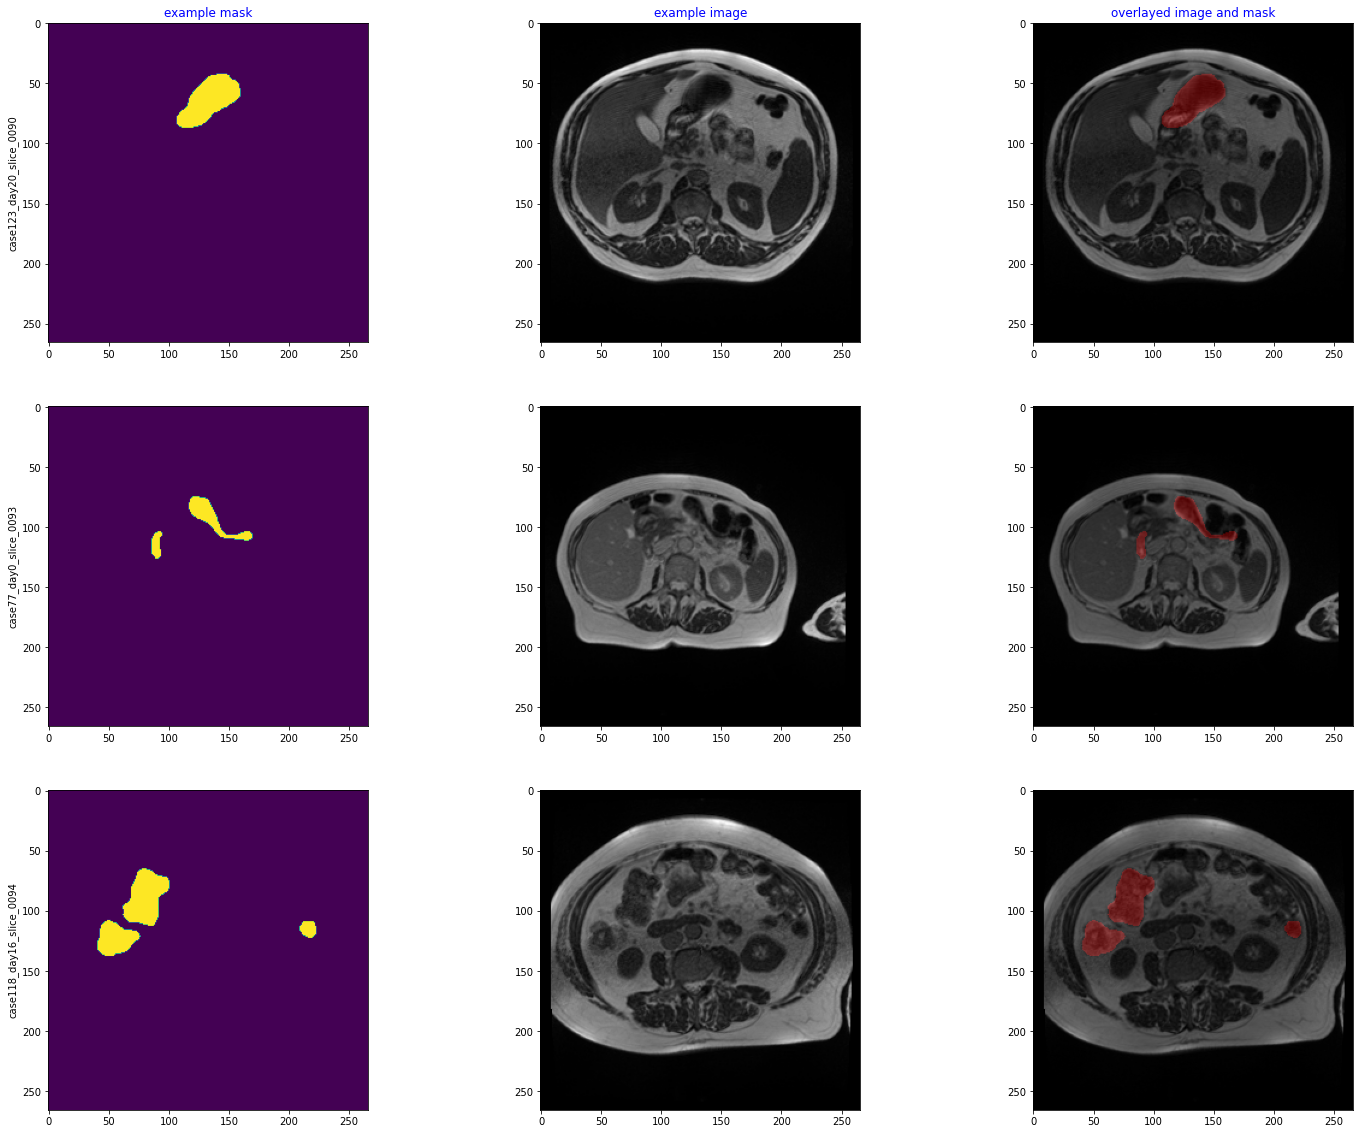

In [19]:
new_df_train_notnan = new_df_train[new_df_train['segmentation'].notnull()] #find all non-nan segmentations
fig, axes = plt.subplots(3,3, figsize = (25, 20))

for j in range(3):
    random_ra = [50,500,5000] #random numbers chosen for random images
    examples = new_df_train_notnan.iloc[random_ra[j]]
    example_mask = decode_rle(rle_mask = examples["segmentation"], mask_shape = (examples["height"],examples["width"]))
    example_mask = example_mask * 255

    if j == 0 : 
        axes[j, 0].set_title("example mask", color='blue')
    axes[j, 0].set_ylabel(examples['id'])
    axes[j, 0].imshow(example_mask)

    example_image = read_uint16_image(path = examples["image_file_path"], normalize = True)
    if j == 0 : 
        axes[j, 1].set_title("example image", color='blue')
    axes[j, 1].imshow(np.array(example_image), cmap = 'gray')

    example_overlay_image = label2rgb(label = example_mask, image = example_image) #np.array(image) / np.array(image).max())
    if j == 0 : 
        axes[j, 2].set_title("overlayed image and mask", color='blue')
    axes[j, 2].imshow(example_overlay_image)

---
### Often times, data augmentation is performed for the training set to not only increase the absolute number of training set, but also increases the variability and flexibility of the model and therefore helps reduce overfitting. Not all data augmentation are useful, however, and figuring this out would just be trial-and-error. Image augmentation can easily be done in Albumentations, read the docs [here](https://albumentations.ai/docs/getting_started/image_augmentation/) and list of augmentations [here](https://albumentations.ai/docs/getting_started/transforms_and_targets/) if you want to.

### Note that other than the resize to 224 x 224 being necessary here, all the other transforms are optional, I've included them after some trial and error myself but most from other references as well. 
---

In [20]:
# Build augmentation pipeline (as seen in docs):
aug_pipeline = {"valid": A.Compose([
    A.Resize(height = 224, width = 224, interpolation = cv2.INTER_NEAREST),],p = 1.0),
    # pre-trained model was trained on 224 x 224, so resize all images to 224 x 224, important!
    # cv2.inter_nearest is the most used! maybe try inter_area as well?
                # p = probabilities of the augmentation happening
                "train": A.Compose([
    A.Resize(height = 224, width = 224, interpolation = cv2.INTER_NEAREST), # resize as well 
    A.ShiftScaleRotate(p=0.5), # randomly shift, scale, rotate images, default parameters used.
    A.VerticalFlip(p=0.5), # vertical flip
    A.HorizontalFlip(p=0.5), # horizontal flip
    A.ElasticTransform(p=1.0) # apply elastic deformation of images (applies filters!)
        ], p=1.0)
                }

### Let's try applying the training augmentation pipeline to one of our images to see how they look like after the augmentation:

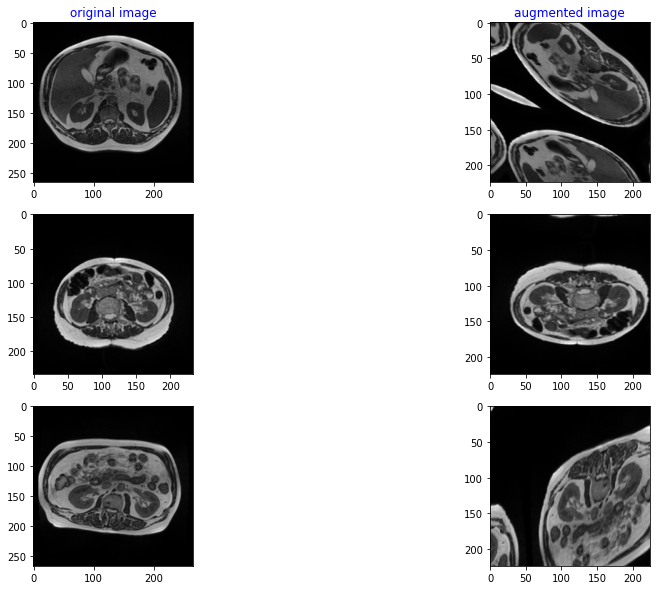

In [21]:
fig, axes = plt.subplots(3,2, figsize = (15, 10))
image_path1 = new_df_train_notnan.iloc[50]["image_file_path"]
image1 = read_uint16_image(path = image_path1, normalize = True)
axes[0][0].set_title("original image", color='blue')
axes[0][0].imshow(image1,cmap="gray")
random.seed(42) #  seed for reproducibility
aug_img1 = aug_pipeline["train"](image=image1)['image']
axes[0][1].set_title("augmented image", color='blue')
axes[0][1].imshow(aug_img1,cmap="gray")

image_path2 = new_df_train_notnan.iloc[2000]["image_file_path"]
image2 = read_uint16_image(path = image_path2, normalize = True)
axes[1][0].imshow(image2,cmap="gray")
random.seed(21) #seed for reproducibility
aug_img2 = aug_pipeline["train"](image=image2)['image']
axes[1][1].imshow(aug_img2,cmap="gray")

image_path3 = new_df_train_notnan.iloc[22000]["image_file_path"]
image3 = read_uint16_image(path = image_path3, normalize = True)
axes[2][0].imshow(image3,cmap="gray")
random.seed(1) #seed for reproducibility
aug_img3 = aug_pipeline["train"](image=image3)['image']
axes[2][1].imshow(aug_img3,cmap="gray")

### Before concluding EDA/data preprocessing, edit the new_train_df to include the length of the rle_mask and a boolean to see if the mask is empty (which means segmentation = NaN). And then group by each slice so that there is only one unique id (there was now three same id's, for each class, but we combine it here):

In [22]:
# len_rle, len(x) of each row, 0 if na
new_df_train['len_rle'] = new_df_train.segmentation.map(lambda x: 0 if isinstance(x,float) else len(x))
new_df_train['is_empty'] = new_df_train.len_rle == 0 #find boolean if len_rle = 0


In [23]:
temp_df = new_df_train.groupby(['id'])['segmentation'].agg(list) #aggregate by id and segmentation
temp_df = temp_df.reset_index() #reset index for merge

temp_group = new_df_train.groupby(['id'])['len_rle'].agg(sum).reset_index()
temp_df = temp_df.merge(temp_group)

new_df_train = new_df_train.drop(columns = ['len_rle','segmentation']) # don't drop class
new_df_train = new_df_train.groupby(['id']).head(1).reset_index(drop=True)
new_df_train = new_df_train.merge(temp_df, on=['id'])
# new_df_train["mask_file_path"] = new_df_train.image_file_path.map(lambda x: )


### Update: While running training, I've realized that the majority of the time is taken by computing the masks from the RLEs! It was taking over 9 hours for just 10 epochs with the UNet, which was outrageous. Therefore, I've fortunately found a dataset that already has all the RLE masks from the respective images. It basically uses the same code as the code that I have above, converting the image to a mask. 

In [24]:
# define all necessary paths (on kaggle):
mask_data_path_dir = "/kaggle/input/uwmgi-mask-dataset/np/uw-madison-gi-tract-image-segmentation"
mask_train_dir = os.path.join(mask_data_path_dir,"train")
entire_train_mask = glob(os.path.join(mask_train_dir,"**","**.npy"), recursive = True) #list of all mask images
print(len(entire_train_mask))

38496


In [25]:
new_df_train["mask_file_path"] = new_df_train.image_file_path.map(lambda x: x.replace('/kaggle/input/','/kaggle/input/uwmgi-mask-dataset/np/'))
new_df_train["mask_file_path"] = new_df_train.mask_file_path.map(lambda x: x.replace('.png','.npy'))
new_df_train.head(n=5)
# print(len(new_df_train)) #38496, which is exactly 1/3 of the previous length (115488)

,id,class,slices,day,case_number,image_file_path,height,width,is_empty,segmentation,len_rle,mask_file_path
0,case123_day20_slice_0001,large_bowel,1,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
1,case123_day20_slice_0002,large_bowel,2,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
2,case123_day20_slice_0003,large_bowel,3,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
3,case123_day20_slice_0004,large_bowel,4,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
4,case123_day20_slice_0005,large_bowel,5,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...


In [26]:
new_df_train.head(n=-10)

,id,class,slices,day,case_number,image_file_path,height,width,is_empty,segmentation,len_rle,mask_file_path
0,case123_day20_slice_0001,large_bowel,1,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
1,case123_day20_slice_0002,large_bowel,2,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
2,case123_day20_slice_0003,large_bowel,3,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
3,case123_day20_slice_0004,large_bowel,4,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
4,case123_day20_slice_0005,large_bowel,5,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
...,...,...,...,...,...,...,...,...,...,...,...,...
38481,case30_day0_slice_0130,large_bowel,130,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17429 9 17690 30 17950 38 18211 45 18475 54 1...,1965,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
38482,case30_day0_slice_0131,large_bowel,131,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17433 4 17692 15 17712 8 17950 38 18211 45 18...,2050,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
38483,case30_day0_slice_0132,large_bowel,132,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17694 11 17713 6 17952 35 18212 44 18476 48 1...,1917,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
38484,case30_day0_slice_0133,large_bowel,133,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17695 8 17957 23 18213 39 18477 45 18741 52 1...,1833,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...


---
<a id="model"></a>
# Model:
### Now, since we have completed exploring and preprocessing the data, we can now work on building the model. However, before actually defining the model and training it, there's a lot we have to do before:
<a id="create-dataset"></a>
## Create Pytorch Dataset
### Pytorch dataset & dataloader [docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) shows what this does. 
---

In [27]:
class MyTrainDataSet(Dataset):
    #initialize labels, transforms, the df, and directory for image and id
    def __init__(self, df, label = True, transforms = None):
        self.df = df
        self.label = label
        self.image_paths = df["image_file_path"].tolist()
        self.mask_paths = df["mask_file_path"].tolist()
#         self.id_list = df["id"].tolist()
        self.transforms = transforms
        

    def __len__(self): # upperbound of idx (index), so how many images we have
        return len(self.df) # length of df is how many images we have
    
    def __getitem__(self,idx): # index = each row of df
        #read image/label, call transform function, and then return tensor image or/and mask!
       
        # read image:
        image_path = self.image_paths[idx] # get image path
        image = cv2.imread(image_path, -1) # read image
        image = np.tile(image[...,None], [1, 1, 3]) # convert image to rgb #np.concatenate((image,)*3, axis=-1).astype('float32')
        max_val = np.max(image) # find max val to scale image from 0 to 1
        image = image/max_val # scale image 
        
        if self.label: # label (mask and image)
#             eyedee = self.id_list[idx]
#             df = self.df
            mask_path = self.mask_paths[idx]
            mask = np.load(mask_path) #npy file
            mask = mask.astype('float32')
            mask = mask / 255.0
            if self.transforms: 
                data = self.transforms(image=image,mask=mask) #apply transforms
                image = data["image"]
                mask = data["mask"]
            #np.transpose(image,(2,0,1)) for HWC->CHW (channel,height,width)
            #transformation, difference between cv2 and pytorch
            #return image and mask as tensors:
            image = np.transpose(image,(2,0,1)) #CHW
            mask = np.transpose(mask,(2,0,1)) #CHW
            return torch.tensor(image), torch.tensor(mask)

### Because we need to iterate with mini-batches (to optimize fitting), we now define a DataLoader to iterate through the custom Dataset we defined above. However, before doing this, it is important to know how the data is divided in the dataset so that we avoid data leakage while splitting the data to training and validation data.

### As seen below, we can see that for each case (total of 85 cases), there are multiple days, and then for each day, there are multiple slices. Each case represents a patient, and the same patient underwent a MRI scan in different/multiple days for treatment. Each day has multiple "slices" (which are essentially just really thin 3D slices (so essentially 2D), but is actually more of a single 3D scan.

In [28]:
num_cases = new_df_train.case_number.nunique()
print("Total number of cases in training dataset: {} cases".format(num_cases))
new_df_train.head(n=-10)

Total number of cases in training dataset: 85 cases


,id,class,slices,day,case_number,image_file_path,height,width,is_empty,segmentation,len_rle,mask_file_path
0,case123_day20_slice_0001,large_bowel,1,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
1,case123_day20_slice_0002,large_bowel,2,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
2,case123_day20_slice_0003,large_bowel,3,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
3,case123_day20_slice_0004,large_bowel,4,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
4,case123_day20_slice_0005,large_bowel,5,20,123,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,True,"[nan, nan, nan]",0,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
...,...,...,...,...,...,...,...,...,...,...,...,...
38481,case30_day0_slice_0130,large_bowel,130,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17429 9 17690 30 17950 38 18211 45 18475 54 1...,1965,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
38482,case30_day0_slice_0131,large_bowel,131,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17433 4 17692 15 17712 8 17950 38 18211 45 18...,2050,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
38483,case30_day0_slice_0132,large_bowel,132,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17694 11 17713 6 17952 35 18212 44 18476 48 1...,1917,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...
38484,case30_day0_slice_0133,large_bowel,133,0,30,/kaggle/input/uw-madison-gi-tract-image-segmen...,266,266,False,[17695 8 17957 23 18213 39 18477 45 18741 52 1...,1833,/kaggle/input/uwmgi-mask-dataset/np/uw-madison...


### Also, it is known to us that for some cases, all of the images (in different days) are only in the training set, but for some cases, only some of the images (earlier days) are in the training set and the other images (later days) are in the hidden test set. Because the goal of building a model is to generalize well to partially seen but also unseen data, we need to make sure that the validation dataset doesn't have the same patients (or cases) as the training dataset. Otherwise, if the training dataset has 50 images for patient (case) 1, and the validation dataset has 20 images for patient (case) 1 as well, the model can learn the features of patient 1 and do well on the validation set, which is what we **don't want**. So we would need to use a GroupKFold.

### Furthermore, as shown before in EDA, there is an imbalance of empty and non-empty cases for each class. Therefore, we would need to use stratification as well. How do we do both– avoid data leakage due to case and account for the class imbalance? We use StratifiedGroupKFold to do both at the same time, which can be read about more in the docs [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html).

In [29]:
strat_group_kfold = StratifiedGroupKFold(shuffle = True, random_state = 1) #use default n_split = 5, random_state for reproducibility

#split (stratification) on is_empty and group (groupkfold) on case_number:
for each_fold, (idx1,idx2) in enumerate (strat_group_kfold.split(X = new_df_train, y = new_df_train['is_empty'], groups = new_df_train['case_number'])):
    new_df_train.loc[idx2,'fold'] = int(each_fold) #create new fold column with the fold number (up to 5)
    
#check if stratification worked by grouping:
grouped = new_df_train.groupby(['fold','case_number','is_empty']) # look how it's splitted
display(grouped.id.count())
grouped1 = new_df_train.groupby(['fold','is_empty'])
display(grouped1.id.count()) # get counts

ratio_list = []
for k in range(5):
    ratio = grouped1.id.count()[k][0]/grouped1.id.count()[k][1]
    ratio_list.append(ratio)
print("the ratios of the folds are: {}".format(ratio_list)) #ratios to check stratification

fold  case_number  is_empty
0.0   11           False       191
                   True        241
      19           False       308
                   True        412
      44           False       159
                              ... 
4.0   130          True        209
      138          False       162
                   True        270
      144          False       168
                   True        264
Name: id, Length: 170, dtype: int64

fold  is_empty
0.0   False       2902
      True        4746
1.0   False       2719
      True        4577
2.0   False       3110
      True        5642
3.0   False       2556
      True        4468
4.0   False       2798
      True        4978
Name: id, dtype: int64

the ratios of the folds are: [0.6114622840286557, 0.5940572427354162, 0.5512229705778093, 0.5720680393912265, 0.5620731217356368]


<a id="model-definition"></a>
## Model Definition: 
### With the dataset created and the StratifiedGroupKFold done, let's define our model:
### SMP github and its tables of available models and encoders found [here]. Here, as our vanilla model, we use a vanilla U-net (U-net as backbone/decoder and resnet18 for encoder) Then, as our method, we use Eff-Unet (U-net as backbone/decoder and efficientnet-b1 for encoder). Efficientnet-b1 has 7M parameters,Efficient-b7 yields better results, but has 64M parameters, will take too long. (https://github.com/qubvel/segmentation_models.pytorch#architectures)

### Just before building our model, build a class that just contains the model hyperparameters so that we can change hyperparameters here anytime and not change them multiple times downstream, which is a hassle:

### Note: It takes ~4 hours for vanilla unet with resnet18 decoder with epoch = 5, so we were unable to do any hyperparameter tuning. Most of these hyperparameter below are the standard default values for the respective model and the learning rate scheduler. 

In [30]:
# use these hyperparameters, comment out one of the encoders to use the other one:
class model_hyperparameters(): 
    encoder_name = "efficientnet-b4" #try efficientnetb1/b4
#     encoder_name = "resnet18" #vanilla Unet usually uses resnet as an encoder
    encoder_weights = "imagenet"
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use gpu on kaggle
    train_batch_size = 64 # explore num of batch size. 64 to 128 to see how faster training is, but maybe worse generalization -> score.
    valid_batch_size = 128 # increase batch from 64 to 128 for faster validation
    epochs = 10 # higher epoch will be better but will take long, 10
    learning_rate = 0.001 # explore different learning rate (Adam optimizer) 0.001 -> 0.002 when train batch size 64 -> 128
    weight_decay = 1e-4 # explore different weight decay (Adam optimizer)
    scheduler = "CosineAnnealingLR" # explore different schedulers
    patience = 5 # for reducelronplateau, explore different values (lower patience for lower epochs)
    min_lr = 1e-6 # for reducelronplateau, explore different values (Default)
    # T_max value is often integer*# of epochs/ length of dataloader or batch size:
    T_max = int(30000/train_batch_size*epochs) # for cosineannealingLR, explore different values
    iters_to_accumulate = max(1,32//train_batch_size) # for scaling accumulated gradients

### Now define a function that returns a dataloader for our training and validation, which is an iterable that will load the dataset we defined in MyTrainDataSet efficiently, with specified batch size and with reshuffling every batch. So, this is where the previous defined MyTrainDataSet is used and the augmentation pipeline defined is used as transforms. 

In [31]:
def load_dataset(fold): 
    # since we have five folds, we do an approximate 80-20 split for each fold (fold != fold is 80%, fold == fold is 20%)
    # when we train, we'll iterate through the folds
    model_df_train = new_df_train.query("fold!=@fold").reset_index(drop=True)
    model_df_valid = new_df_train.query("fold==@fold").reset_index(drop=True)
    # build the dataset using the dataset class we defined previously
    # note the aug_pipeline that we defined as a dictionary is used here as the transforms!
    train_dataset = MyTrainDataSet(df = model_df_train, transforms = aug_pipeline["train"]) 
    valid_dataset =  MyTrainDataSet(df = model_df_valid, transforms = aug_pipeline["valid"])
    train_dataloader = DataLoader(dataset = train_dataset, 
            batch_size = model_hyperparameters.train_batch_size, # num_workers = 2 is the max value for the process
            num_workers = 2, pin_memory = True, shuffle = True) # pin_memory= true allows faster data transport from cpu to gpu
    valid_dataloader = DataLoader(dataset = valid_dataset, 
            batch_size = model_hyperparameters.valid_batch_size, 
            num_workers = 2, pin_memory = True, shuffle = False)
    return train_dataloader, valid_dataloader

### Let's now check the tensor size of the returned batches for train and valid. They should be a 4-D tensor with (batch_size,num_channel, height,width), where batch_size is whatever's defined in the hyperparameters, num_channel = 3 (rgb), and height and width of the image should all be 224 x 224, since they were all resized to this. This is indeed true as shown below:


In [32]:
train_dataloader, valid_dataloader = load_dataset(fold = 0)
images, masks = next(iter(train_dataloader))
print("Images have a tensor size of {}, and Masks have a tensor size of {}".
      format(images.size(),masks.size()))

Images have a tensor size of torch.Size([64, 3, 224, 224]), and Masks have a tensor size of torch.Size([64, 3, 224, 224])


### Build the Eff-Unet Model: This model uses a predefined model architecture (note smp.Unet and the encoder_name) and a pretrained Imagenet weights as well. The Unet model documentation can be found [here](https://smp.readthedocs.io/en/latest/models.html#unet).

In [33]:
def build_my_model():
    model = smp.Unet(encoder_name = model_hyperparameters.encoder_name, 
             encoder_weights = model_hyperparameters.encoder_weights, #pre-trained weights
             in_channels = 3, # RGB
             classes = 3)  # we have three classes (stomach, large bowel, small bowel)
    model.to(model_hyperparameters.device) # move model to gpu
    return model

<a id="loss-function"></a>
## Define Loss Function: 

### After checking that dataloader works properly and building the model, all we have to do is to define the loss function before we start training. We'll do an weighted average of the binary cross entropy(BCE) loss and the dice loss. The BCE loss and dice loss used below can both be found [here](https://smp.readthedocs.io/en/latest/losses.html). I was originally going to use only dice loss, but I'll be taking in TA's advice, so I tried to do a weighted average of them.


In [34]:
# both loss func utilizes N * C * H * W tensors for y_pred and y_true, which is indeed our case.
dice_loss_func = smp.losses.DiceLoss(mode='multilabel')
bce_loss_func = smp.losses.SoftBCEWithLogitsLoss()
# TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def custom_loss_func(y_pred,y_true): #weighted avg of the two, explore other loss func
    return  0.5 * dice_loss_func (y_pred,y_true) + 0.5 * bce_loss_func(y_pred,y_true)


### Function to fetch dice coefficient: This function is used to find the dice coefficient for each input. 

In [35]:
def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    intersection = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*intersection+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

<a id="training"></a>
## Training: 
### The below is the function used for training one epoch, this way we can just call this function later over a for loop with range(epochs). Here, I've tried utilizing what's called "automatic mixed precision", which the source code was found [here](https://pytorch.org/docs/stable/amp.html) and [here](https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html) and [here](https://pytorch.org/docs/stable/notes/amp_examples.html). Automatic mixed precision allows us to speed up math-intensive and memory-limited operations and reduce memory requirements, as mentioned [here](https://developer.nvidia.com/automatic-mixed-precision). There are two major changes: one is utilizing the GradScaler and another is utilizing Autocast. GradScaler efficiently performs gradient scaling, which minimizes gradient underflow. Autocast is the one that runs with mixed precision (lowers precision but maintains accuracy) to speed up calculations.

In [36]:

def epoch_train(model, optimizer, scheduler, dataloader, device, epoch):
    model.train() # set mode to train
    dataset_size = 0 #initialize 
    running_loss = 0.0 #initialize
    scaler = GradScaler() # enable GradScaler
    pbar = tqdm(enumerate(dataloader), total = len(dataloader), desc='Train')
    for idx, (images, masks) in pbar:         
        images = images.to(device, dtype=torch.float) # move tensor to gpu
        masks  = masks.to(device, dtype=torch.float) # move tensor to gpu
        batch_size = images.size(0) # return batch size (N*C*H*W), or N (64)
        
        with autocast(enabled=True): # enable autocast for forward pass
            y_pred = model(images) # forward pass, get y_pred from input
            loss   = custom_loss_func(y_pred, masks) # compute losses from y_pred
            loss   = loss / model_hyperparameters.iters_to_accumulate # need to normalize since accumulating gradients
        scaler.scale(loss).backward() # accumulates the scaled gradients
        
        if (idx + 1) % model_hyperparameters.iters_to_accumulate == 0: 
            scaler.step(optimizer) 
            scaler.update() # update scale for next iteration
            optimizer.zero_grad() # zero the accumulated scaled gradients
            scheduler.step() # change lr,make sure to call this after scaler.step
                
        running_loss += (loss.item() * batch_size) # update current running loss
        dataset_size += batch_size # update current datasize
        
        epoch_loss = running_loss / dataset_size # divide epoch loss by current datasize
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(train_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}')
        
    torch.cuda.empty_cache() #clear gpu memory after every epoch
    gc.collect()
    
    return epoch_loss #return loss for this epoch

In [37]:
@torch.no_grad() # disable gradient calc for validation
def epoch_valid(model, dataloader, device, epoch):
    model.eval() # set mode to eval
    dataset_size = 0 #initialize 
    running_loss = 0.0 #initialize
    valid_score_history = [] #keep validation score
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc='Validation')
    for idx, (images, masks) in pbar:        
        images  = images.to(device, dtype=torch.float)
        masks   = masks.to(device, dtype=torch.float)
        batch_size = images.size(0)
        y_pred  = model(images)
        loss    = custom_loss_func(y_pred, masks)
    
        running_loss += (loss.item() * batch_size) #update current running loss
        dataset_size += batch_size #update current datasize
        epoch_loss = running_loss / dataset_size #divide epoch loss by current datasize
        
        y_pred = nn.Sigmoid()(y_pred) #sigmoid for multi-label classification
        valid_dice = dice_coef(masks, y_pred).cpu().detach().numpy() # fetch dice_coef
        valid_score_history.append(valid_dice)
        
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.3f}',
                        lr=f'{current_lr:0.4f}')
    valid_score_history  = np.mean(valid_score_history, axis=0)
    torch.cuda.empty_cache() #clear gpu memory after every epoch
    gc.collect()
    
    return epoch_loss, valid_score_history #return loss and valid_score_history for this epoch


In [38]:
def run_training(model, optimizer, scheduler, device, num_epochs):
   
    start = time.time() # measure time
    best_model_wts = copy.deepcopy(model.state_dict()) #deepcopy
    best_dice      = 0 # initial best score
    best_epoch     = -1 # initial best epoch
    history = defaultdict(list) # history defaultdict to store relevant variables
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        print(f'Epoch {epoch}/{num_epochs}', end='')
        train_loss = epoch_train(model, optimizer, scheduler, 
                                           dataloader=train_dataloader, 
                                           device=model_hyperparameters.device, epoch=epoch)
        valid_loss, valid_score_history = epoch_valid(model, valid_dataloader, 
                                                 device=model_hyperparameters.device, 
                                                 epoch=epoch)
        valid_dice = valid_score_history
        history['Train Loss'].append(train_loss)
        history['Valid Loss'].append(valid_loss)
        history['Valid Dice'].append(valid_dice)
        
        print(f'Valid Dice: {valid_dice:0.4f}')
        
        # if dice score improves, save the best model
        if valid_dice >= best_dice:
            print(f"Valid Score Improved ({best_dice:0.4f} ---> {valid_dice:0.4f})")
            best_dice    = valid_dice
            best_epoch   = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"best_epoch-{fold:02d}.bin"
            torch.save(model.state_dict(), PATH) #current directory (on kaggle)
            print("Model Saved!")
        
        # save the most recent model
        last_model_wts = copy.deepcopy(model.state_dict())
        PATH = f"last_epoch-{fold:02d}.bin" #current directory (on kaggle)
        torch.save(model.state_dict(), PATH)
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60))
    print("Best Score: {:.4f}".format(best_dice))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [39]:
# if resnet, use resnet pre-downloaded:
if model_hyperparameters.encoder_name == "resnet18":
    !mkdir -p /root/.cache/torch/hub/checkpoints
    !cp ../input/resnet18/resnet18-5c106cde.pth /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
# if efficietnet, use efficient net pre-downloaded:
if model_hyperparameters.encoder_name == "efficientnet-b1":
    !mkdir -p /root/.cache/torch/hub/checkpoints
    !cp ../input/efficientnetb1pretrained/efficientnet-b1-f1951068.pth /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
if model_hyperparameters.encoder_name == "efficientnet-b4":
    !mkdir -p /root/.cache/torch/hub/checkpoints
    !cp ../input/efficientnetb4pretrained/efficientnet-b4-6ed6700e.pth /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
if model_hyperparameters.encoder_name == "efficientnet-b6":
    !mkdir -p /root/.cache/torch/hub/checkpoints
    !cp ../input/efficientnetb6pretrained/efficientnet-b6-c76e70fd.pth /root/.cache/torch/hub/checkpoints/efficientnet-b6-c76e70fd.pth

In [40]:
model = build_my_model()
optimizer = optim.Adam(model.parameters(), 
                       lr=model_hyperparameters.learning_rate, 
                       weight_decay = model_hyperparameters.weight_decay ) # default learning rate

if model_hyperparameters.scheduler == "CosineAnnealingLR": # change to CosineAnnealingLR
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max = model_hyperparameters.T_max, 
                                               eta_min =  model_hyperparameters.min_lr)

if model_hyperparameters.scheduler == "ReduceLROnPlateau": # change to ReduceLR
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 
                                                   patience = model_hyperparameters.patience, 
                                                   min_lr =  model_hyperparameters.min_lr)

In [41]:
for fold in range(1):
    print(f'Fold: {fold}')
    train_dataloader, valid_dataloader = load_dataset(fold = fold)
    model     = build_my_model()
    optimizer = optim.Adam(model.parameters(), 
                           lr=model_hyperparameters.learning_rate, 
                           weight_decay=model_hyperparameters.weight_decay)
    
    if model_hyperparameters.scheduler == "CosineAnnealingLR": # change to CosineAnnealingLR
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 
                                                   T_max = model_hyperparameters.T_max, 
                                                   eta_min =  model_hyperparameters.min_lr)
    if model_hyperparameters.scheduler == "ReduceLROnPlateau": # change to ReduceLR
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 
                                                   patience = model_hyperparameters.patience, 
                                                   min_lr =  model_hyperparameters.min_lr)
    model, history = run_training(model, optimizer, scheduler,
                                  device=model_hyperparameters.device,
                                  num_epochs=model_hyperparameters.epochs)



Fold: 0
Epoch 1/10

Validation: 100%|██████████| 60/60 [01:41<00:00,  1.69s/it, lr=0.0010, valid_loss=0.390]


Valid Dice: 0.5241
Valid Score Improved (0.0000 ---> 0.5241)
Model Saved!
Epoch 2/10

Validation: 100%|██████████| 60/60 [01:26<00:00,  1.45s/it, lr=0.0009, valid_loss=0.231]


Valid Dice: 0.8135
Valid Score Improved (0.5241 ---> 0.8135)
Model Saved!
Epoch 3/10

Validation: 100%|██████████| 60/60 [01:43<00:00,  1.72s/it, lr=0.0008, valid_loss=0.202]


Valid Dice: 0.8485
Valid Score Improved (0.8135 ---> 0.8485)
Model Saved!
Epoch 4/10

Validation: 100%|██████████| 60/60 [01:26<00:00,  1.45s/it, lr=0.0006, valid_loss=0.191]


Valid Dice: 0.8482
Epoch 5/10

Validation: 100%|██████████| 60/60 [01:40<00:00,  1.68s/it, lr=0.0005, valid_loss=0.160]


Valid Dice: 0.8385
Epoch 6/10

Validation: 100%|██████████| 60/60 [01:23<00:00,  1.40s/it, lr=0.0003, valid_loss=0.150]


Valid Dice: 0.8721
Valid Score Improved (0.8485 ---> 0.8721)
Model Saved!
Epoch 7/10

Validation: 100%|██████████| 60/60 [01:45<00:00,  1.76s/it, lr=0.0002, valid_loss=0.139]


Valid Dice: 0.8719
Epoch 8/10

Validation: 100%|██████████| 60/60 [01:29<00:00,  1.50s/it, lr=0.0001, valid_loss=0.137]


Valid Dice: 0.8829
Valid Score Improved (0.8721 ---> 0.8829)
Model Saved!
Epoch 9/10

Validation: 100%|██████████| 60/60 [01:48<00:00,  1.80s/it, lr=0.0000, valid_loss=0.133]


Valid Dice: 0.8870
Valid Score Improved (0.8829 ---> 0.8870)
Model Saved!
Epoch 10/10

Validation: 100%|██████████| 60/60 [01:28<00:00,  1.47s/it, lr=0.0000, valid_loss=0.133]


Valid Dice: 0.8872
Valid Score Improved (0.8870 ---> 0.8872)
Model Saved!
Training complete in 7h 41m
Best Score: 0.8872


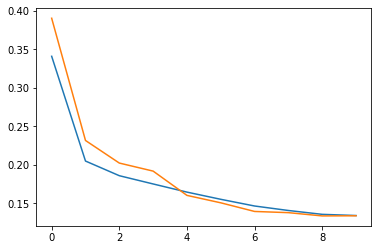

In [42]:
# plot
train_loss = history["Train Loss"]
valid_loss = history["Valid Loss"]
epochs = np.array(range(0,model_hyperparameters.epochs))
plt.plot(epochs,train_loss)
plt.plot(epochs,valid_loss)
plt.show()

# Inference:


In [43]:
def masks_to_rle(masks, ids, heights, widths):
    pred_strings = []; pred_ids = []; pred_classes = [];
    for idx in range(masks.shape[0]):
        height = heights[idx].item()
        width = widths[idx].item()
        mask = cv2.resize(masks[idx], 
                         dsize=(width, height), 
                         interpolation=cv2.INTER_NEAREST) # back to original shape
        rle = [None]*3
        for maskidx in [0, 1, 2]:
            rle[maskidx] = encode_rle(mask[...,maskidx])
        pred_strings.extend(rle)
        pred_ids.extend([ids[idx]]*len(rle))
        pred_classes.extend(['large_bowel', 'small_bowel', 'stomach'])
    return pred_strings, pred_ids, pred_classes

In [44]:
@torch.no_grad()
def infer(model_paths, test_loader, thr= 0.4):
    pred_strings = []
    pred_classes = []
    pred_ids = [] 
    masks = []
    images = []
     
    for idx, (image, ids, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Inference')):
        image = image.to(model_hyperparameters.device, dtype=torch.float) # .squeeze(0)
        size = image.size()
        mask = []
        mask = torch.zeros((size[0], 3, size[2], size[3]), device=model_hyperparameters.device, dtype=torch.float32)
        for path in model_paths:
            model = build_my_model()
            model.load_state_dict(torch.load(path))
            model.eval()
            output   = model(image) # .squeeze(0) # removing batch axis
            output   = nn.Sigmoid()(output) # removing channel axis
            mask+= output / len(model_paths)
        mask = (mask.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        result = masks_to_rle(mask, ids, heights, widths)
        pred_strings.extend(result[0])
        pred_ids.extend(result[1])
        pred_classes.extend(result[2])
    
    pred_df = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_strings})
    return pred_df, images, masks

### On Kaggle, even though test data is hidden, when the notebook is submitted (it runs on a separate, unseen Kaggle environmnent), it puts in the test images to be tested in the test folder that is unavailable when training (before submitting). But we still have to create a test_df which is in the same format as the submission.csv, with the prediction column empty. 

In [45]:
submission_df = pd.read_csv(sample_submission_dir)
test_set_hidden = not bool(len(submission_df))
print(test_set_hidden)

if test_set_hidden:
    test_df = pd.read_csv(train_csv_dir)[: 1000 * 3]
    test_df = test_df.drop(columns=["class", "segmentation"]).drop_duplicates()
    image_paths = entire_train_image
else:
    test_df = submission_df.drop(columns=["class", "predicted"]).drop_duplicates()
    image_paths = glob(f'/kaggle/input/uw-madison-gi-tract-image-segmentation/test/**/*png', recursive=True)
    print(len(image_paths))

test_df = test_df.apply(edit_csv_data, axis = 1)

path_df = pd.DataFrame(image_paths, columns=["image_file_path"])
path_df = path_df.apply(edit_path_data, axis = 1)

test_df = test_df.merge(path_df, on=["case_number", "day", "slices"], how="left")
print(len(test_df))
test_df.head()
test_df.to_csv("test_preprocessed.csv", index=False)

True
1000


In [46]:
class MyTestDataSet(Dataset):
    #initialize transforms, the df, and directory for image and id
    def __init__(self, df, transforms = None):
        self.df = df
        self.id_list = df["id"].tolist()
        self.image_paths = df["image_file_path"].tolist()
        self.transforms = transforms
        
    def __len__(self): # upperbound of idx (index), so how many images we have
        return len(self.df) # length of df is how many images we have
    
    def __getitem__(self,idx): # index = each row of df
        #read image, call transform function, and then return tensor image!
       
        # read image:
        image_path = self.image_paths[idx] # get image path
        eyedee = self.id_list[idx]
        image = cv2.imread(image_path, -1) # read image
        image = np.tile(image[...,None], [1, 1, 3]) # convert image to rgb #np.concatenate((image,)*3, axis=-1).astype('float32')
        max_val = np.max(image) # find max val to scale image from 0 to 1
        image = image/max_val # scale image 
        height = image.shape[0]
        width = image.shape[1]
        
        if self.transforms: 
            data = self.transforms(image=image) #apply transforms
            image = data["image"]
            #return image as tensor:
            image = np.transpose(image,(2,0,1)) #CHW
            return torch.tensor(image), eyedee, height, width

In [47]:
test_dataset = MyTestDataSet(test_df, transforms = aug_pipeline['valid'])
test_loader  = DataLoader(test_dataset, batch_size=model_hyperparameters.valid_batch_size, 
                          num_workers=2)
saved_model_path = "/kaggle/working"
model_paths  = glob(f'{saved_model_path}/best_epoch*.bin')
pred_df, images, masks = infer(model_paths, test_loader)

Inference: 100%|██████████| 8/8 [00:15<00:00,  1.91s/it]


In [48]:
if not test_set_hidden:
    submission_df = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/sample_submission.csv")
    del submission_df["predicted"]
else:
    submission_df = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")[: 1000 * 3]
    del submission_df["segmentation"]

submission_df = submission_df.merge(pred_df, on=["id", "class"])
submission_df.to_csv("submission.csv", index=False)
display(submission_df.head(5))

,id,class,predicted
0,case123_day20_slice_0001,large_bowel,
1,case123_day20_slice_0001,small_bowel,
2,case123_day20_slice_0001,stomach,
3,case123_day20_slice_0002,large_bowel,
4,case123_day20_slice_0002,small_bowel,


<a id="evaluation"></a>
# Evaluation of the Model:

Validation loss and accuracy as a method of tuning (prevent overfitting)


<a id="results"></a>
## Results:

<a id="tuning"></a>
## Tuning:

<a id="credit-references"></a>
# Credit/References

### All of the links in the markdown in the notebook and other references consulted are listed below (some code-related/some just information):
- https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation
- https://www.kaggle.com/competitions/uw-madison-gi-tract-image-segmentation/overview/evaluation
- https://openaccess.thecvf.com/content_CVPRW_2020/papers/w22/Baheti_Eff-UNet_A_Novel_Architecture_for_Semantic_Segmentation_in_Unstructured_Environment_CVPRW_2020_paper.pdf
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8217246/
- https://www.kaggle.com/code/dschettler8845/uwm-gi-tract-image-segmentation-eda/notebook#modelling
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://github.com/qubvel/segmentation_models.pytorch
- https://www.kaggle.com/code/paulorzp/run-length-encode-and-decode/script
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedGroupKFold.html
- https://albumentations.ai/docs/getting_started/transforms_and_targets/
- https://arxiv.org/pdf/2006.14822.pdf
- https://pytorch.org/docs/stable/notes/amp_examples.html
- https://www.kaggle.com/code/awsaf49/uwmgi-mask-data/notebook
- https://smp.readthedocs.io/en/latest/losses.html
- https://albumentations.ai/docs/getting_started/image_augmentation/
- https://developer.nvidia.com/automatic-mixed-precision
- https://www.kaggle.com/code/fabiendaniel/image-with-masks-quick-overview/comments
- https://pytorch.org/tutorials/recipes/recipes/amp_recipe.html
- https://arxiv.org/pdf/2006.14822.pdf

